In [1]:
import logging
import yaml

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import wandb

from helper import *
from lstm_sweep import *


activation_function="sigmoid"
batch_size=64
dropout_prob=0.3837324871365909
hidden_size=64
learning_rate=0.005248057362896184
lookback=5
loss_function="huber"
num_layers=2
optimizer="sgd"



df, f_preprocessor, t_preprocessor, cols = create_data("./data/train.csv", type='train')
df_sub, _, _, _ = create_data("./data/test.csv", type='test')

df = df.drop(columns=["date"], axis=1)
df_sub = df_sub.drop(columns=["date"], axis=1)
df_sub = df_sub[cols]
df.head()



2023-03-22 20:01:09,261 - INFO - Reading train data from ./data/train.csv
2023-03-22 20:01:09,266 - INFO - Start date: 2015-02-19
2023-03-22 20:01:09,267 - INFO - End date: 2021-12-31
2023-03-22 20:01:09,270 - INFO - missing days: 154
2023-03-22 20:01:09,270 - INFO - Featurizing time series data
2023-03-22 20:01:09,304 - INFO - Featurizing XML data
2023-03-22 20:01:14,512 - INFO - Imputing missing values...
2023-03-22 20:01:14,514 - INFO - Creating interactions...
2023-03-22 20:01:14,515 - INFO - Saving to Parquet file...
2023-03-22 20:01:14,553 - INFO - Reading test data from ./data/test.csv
2023-03-22 20:01:14,555 - INFO - Featurizing time series data
2023-03-22 20:01:14,567 - INFO - Featurizing XML data
2023-03-22 20:01:19,632 - INFO - Imputing missing values...
2023-03-22 20:01:19,634 - INFO - Creating interactions...
2023-03-22 20:01:19,635 - INFO - Saving to Parquet file...


,sleep_hours,day_of_year,doy_sin,doy_cos,BasalEnergyBurned,BodyMass,BodyMass_hours_between,FlightsClimbed,FlightsClimbed_hours_between,StepCount,StepCount_hours_between,BodyMassIndex,DistanceWalkingRunning,DistanceWalkingRunning_hours_between,distance_per_step,calorie_per_step,calorie_per_distance
0,6.400000,50,0.758306,0.651899,1898.0,188.799,24.0,NaN,NaN,2669.0,24.0,23.5981,1.31187,24.0,0.000492,0.711128,1446.789697
1,7.583333,51,0.769415,0.638749,1898.0,188.799,24.0,NaN,NaN,14552.0,24.0,23.5981,7.16791,24.0,0.000493,0.130429,264.791271
2,6.350000,52,0.780296,0.625411,1898.0,188.799,24.0,NaN,NaN,7769.0,24.0,23.5981,3.82391,24.0,0.000492,0.244304,496.350594
3,6.500000,53,0.790946,0.611886,1898.0,188.799,24.0,NaN,NaN,16675.0,24.0,23.5981,8.19599,24.0,0.000492,0.113823,231.576661
4,8.916667,54,0.801361,0.598181,1898.0,188.799,24.0,NaN,NaN,6076.0,24.0,23.5981,2.98648,24.0,0.000492,0.312377,635.530792


In [4]:
# compare columns between df and df_sub
cols = df.columns
cols_sub = df_sub.columns
print(cols)
print(cols_sub)


Index(['sleep_hours', 'day_of_year', 'doy_sin', 'doy_cos', 'BasalEnergyBurned',
       'BodyMass', 'BodyMass_hours_between', 'FlightsClimbed',
       'FlightsClimbed_hours_between', 'StepCount', 'StepCount_hours_between',
       'BodyMassIndex', 'DistanceWalkingRunning',
       'DistanceWalkingRunning_hours_between', 'distance_per_step',
       'calorie_per_step', 'calorie_per_distance'],
      dtype='object')
Index(['day_of_year', 'doy_sin', 'doy_cos', 'BasalEnergyBurned', 'BodyMass',
       'BodyMass_hours_between', 'FlightsClimbed',
       'FlightsClimbed_hours_between', 'StepCount', 'StepCount_hours_between',
       'BodyMassIndex', 'DistanceWalkingRunning',
       'DistanceWalkingRunning_hours_between', 'distance_per_step',
       'calorie_per_step', 'calorie_per_distance'],
      dtype='object')


In [5]:
# create input sequences and corresponding target variables
X, y = create_sequences(df.values, lookback)
X_sub = create_input_sequences(df_sub.values, lookback)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


print(X_train.shape)
print(X_sub.shape)

X_train = f_preprocessor.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = f_preprocessor.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_sub = f_preprocessor.transform(X_sub.reshape(-1, X_sub.shape[-1])).reshape(X_sub.shape)

y_train = t_preprocessor.fit_transform(y_train.reshape(-1, 1))
y_test = t_preprocessor.transform(y_test.reshape(-1, 1))
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
sub_dataset = TimeSeriesPredictionDataset(X_sub)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
sub_loader = DataLoader(sub_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
output_size = 1

# move the training and testing data to the device
X_train, y_train = torch.Tensor(X_train).float(), torch.Tensor(y_train).float()
X_test, y_test = torch.Tensor(X_test).float(), torch.Tensor(y_test).float()

# set the device to use for training and evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define the model
model = TimeSeriesModel(input_size=X_train.shape[-1], hidden_size=hidden_size, output_size=1, num_layers=num_layers, dropout_prob=dropout_prob, activation_function=activation_function).to(device)
model = torch.compile(model)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train and evaluate the model
epochs = 500
for epoch in range(epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    valid_loss = evaluate_model(model, test_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")
    #wandb.log({"Epoch": epoch + 1})



(2001, 5, 17)
(414, 5, 16)


ValueError: X has 16 features, but SimpleImputer is expecting 17 features as input.

In [7]:
predictions = predict(model, sub_loader, device)

predictions = t_preprocessor.named_steps['scaler'].inverse_transform(predictions.reshape(-1, 1))

print(predictions)

[[7.0538588]
 [7.2742333]
 [7.378354 ]
 [7.4427714]
 [7.6388507]
 [7.648819 ]
 [7.645932 ]
 [7.6444063]
 [7.441675 ]
 [7.3056264]
 [7.2115026]
 [7.0822587]
 [6.961571 ]
 [6.9791474]
 [6.977649 ]
 [6.973366 ]
 [7.0581183]
 [7.0772595]
 [7.0870204]
 [7.1021347]
 [7.1742363]
 [7.1630754]
 [7.1668286]
 [7.127699 ]
 [7.1071715]
 [7.094933 ]
 [7.047677 ]
 [7.0888333]
 [7.0350213]
 [7.0537643]
 [7.0062833]
 [6.9938507]
 [7.010984 ]
 [7.0045257]
 [6.9946165]
 [7.0060005]
 [7.177672 ]
 [7.16408  ]
 [7.1635466]
 [7.293997 ]
 [7.147827 ]
 [7.132917 ]
 [7.051979 ]
 [6.962514 ]
 [6.967146 ]
 [7.029687 ]
 [7.0719404]
 [7.076133 ]
 [7.079974 ]
 [7.084371 ]
 [7.0894775]
 [7.0889473]
 [7.0876064]
 [7.1165767]
 [7.1270847]
 [7.138811 ]
 [7.061062 ]
 [6.915508 ]
 [6.9047017]
 [6.9055047]
 [7.046588 ]
 [7.043756 ]
 [7.0439954]
 [7.0418816]
 [7.036885 ]
 [7.039298 ]
 [7.0343876]
 [7.0892324]
 [7.126196 ]
 [7.1664243]
 [7.1278934]
 [6.9375477]
 [6.938238 ]
 [6.9351716]
 [6.933299 ]
 [7.0219545]
 [7.0195956]

In [12]:
sub = pd.read_csv('./data/sample_submission.csv')

# Make sure sorted by date
sub = sub.sort_values(by='date')

# Fill in lookback predictions with median
p = pd.Series(index=df_sub.index, dtype=float)
p[:lookback] = 6.68 # median Sleep hours
p[lookback:] = predictions.squeeze()

sub['sleep_hours'] = p
sub.to_csv('./submissions/submission_gru.csv', index=False)

sub.tail()
# kaggle competitions submit -c kaggle-pog-series-s01e04 -f ./submissions/submission_gru.csv -m "Trying GRU model"

,date,sleep_hours
414,2023-03-12,7.273919
415,2023-03-13,7.315058
416,2023-03-14,7.592734
417,2023-03-15,7.571480
418,2023-03-16,7.588531


<Axes: ylabel='Frequency'>

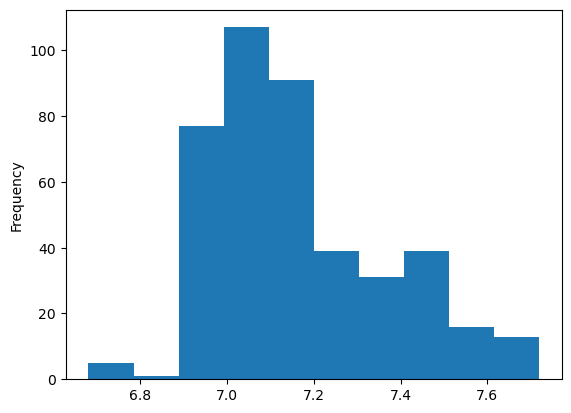

In [15]:
sub['sleep_hours'].plot.hist()